In [1]:
import sys
sys.path.extend(['..', '../bprime'])
    
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import os
import json
import time
import pickle
from multiprocessing import Pool
import itertools

import numpy as np
import scipy.stats as stats
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

import pandas as pd
import statsmodels.api as sm

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

from bprime.utils import index_cols
from bprime.sim_utils import read_params
from bprime.plots import surface_plot
from bprime.learn import LearnedFunction
from bprime.theory import bgs_segment, bgs_rec

os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [3]:
lowess = sm.nonparametric.lowess

In [4]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200
plt.style.use('./buffalo.mplstyle')


In [5]:
def log_tick_formatter(val, pos=None):
    return f"$10^{{{np.round(val, 1)}}}$"

In [6]:
bgs_rec(1e-8, 1e-3, 1e-8, 1e3)

array(0.99005003)

## Data

In [7]:
with open('../slim_sims/training/fullbgs.json') as f:
    sim_config = json.load(f)
sim_params = read_params(sim_config)
sim_params

{'N': (1000, 1000, False),
 'mu': (5.5e-09, 1e-05, False),
 's': (-5.0, -1.0, True),
 'h': (0.5, 0.5, False),
 'rbp': (1e-09, 5e-08, False),
 'rf': (-8.0, -6.0, True),
 'seglen': (10, 1000, False)}

In [8]:
sim_data = np.load('../data/slim_sims/fullbgs_data.npz', allow_pickle=True)

In [9]:
Xcols = index_cols(sim_data['features'])
ycols = index_cols(sim_data['targets'])
sim_data['features'], sim_data['targets']

(array(['N', 's', 'h', 'mu', 'rf', 'rbp', 'seglen'], dtype='<U6'),
 array(['pi', 'Bhat', 'Ef', 'Vf', 'load'], dtype='<U4'))

In [10]:
assert len(sim_data['features']) == sim_data['X'].shape[1]

In [11]:
Xo, yo = np.array(sim_data['X']), sim_data['y']
Xo.shape, yo.shape

((183019, 7), (183019, 5))

In [12]:
# make sure we only have one population size
assert len(np.unique(Xo[:, Xcols('N')])) == 1

To be aligned with classic BGS theory, let's parameterize the heterozygous effect as $sh$. We build up our training dataset:

In [13]:
X = np.hstack((np.prod(Xo[:, Xcols('s', 'h')], axis=1)[:, None], 
               Xo[:, Xcols('mu')], 
               Xo[:, Xcols('rbp')],
               Xo[:, Xcols('rf')],
               Xo[:, Xcols('seglen')]))
X_columns = ('s', 'mu', 'rbp', 'rf', 'seglen')
X

array([[3.9705e-05, 7.4460e-06, 7.2520e-09, 1.4240e-07, 6.1000e+01],
       [2.4945e-04, 1.4810e-06, 3.4060e-08, 2.3480e-08, 9.4300e+02],
       [2.1490e-05, 1.5030e-06, 1.2410e-08, 3.1540e-07, 1.4900e+02],
       ...,
       [1.1265e-03, 8.1720e-06, 1.6190e-08, 1.0610e-08, 4.4700e+02],
       [1.5785e-04, 5.7270e-06, 2.3600e-08, 7.3290e-08, 4.5000e+01],
       [8.3800e-04, 6.3630e-06, 4.5300e-08, 3.2050e-08, 5.5200e+02]])

Now extract the target, $\hat{B}$.

In [14]:
y = yo[:, ycols('Bhat')]

Use the `LearnedFunction` class to store data, etc.

In [15]:
sim_params

{'N': (1000, 1000, False),
 'mu': (5.5e-09, 1e-05, False),
 's': (-5.0, -1.0, True),
 'h': (0.5, 0.5, False),
 'rbp': (1e-09, 5e-08, False),
 'rf': (-8.0, -6.0, True),
 'seglen': (10, 1000, False)}

In [16]:
# h is fixed
assert sim_params['h'][0] == sim_params['h'][1]
h = sim_params['h'][0]

# rename seglen to something shorter...
rename = {'seglen': 'L'}

# rescale s bounds
rescale = {'s': lambda l, u, log10: (np.round(np.log10((10**l)*h), 3), np.round(np.log10((10**u)*h), 3), True)}

domain = {}
for col in X_columns:
    colname = rename.get(col, col)
    rescaler = rescale.get(col, None)
    
    bounds = sim_params[col]
    if rescaler is not None:
        bounds = rescaler(*bounds)
    domain[colname] = bounds

func = LearnedFunction(X, y, domain=domain)
func

LearnedFunction with 5 feature(s) and 1 target(s)
 feature(s):
  - s ∈ [-5.3, -1.3] (log10, None)
  - mu ∈ [5.5e-09, 1e-05] (linear, None)
  - rbp ∈ [1e-09, 5e-08] (linear, None)
  - rf ∈ [-8.0, -6.0] (log10, None)
  - L ∈ [10, 1000] (linear, None)
Features normalized? False
Features split? False

In [17]:
func.split(random_state=6)

LearnedFunction with 5 feature(s) and 1 target(s)
 feature(s):
  - s ∈ [-5.3, -1.3] (log10, None)
  - mu ∈ [5.5e-09, 1e-05] (linear, None)
  - rbp ∈ [1e-09, 5e-08] (linear, None)
  - rf ∈ [-8.0, -6.0] (log10, None)
  - L ∈ [10, 1000] (linear, None)
Features normalized? False
Features split? True, test size: 10.0%

In [18]:
func.X_train.shape

(164717, 5)

In [19]:
func.bounds

{'s': (-5.301, -1.301),
 'mu': (5.5e-09, 1e-05),
 'rbp': (1e-09, 5e-08),
 'rf': (-8.0, -6.0),
 'L': (10, 1000)}

In [20]:
#feature_transforms = {'mu': np.log10, 's': np.log10, 'recfrac': np.log10}
feature_transforms = {'mu': None, 's': np.log10, 'rf': np.log10}
func.scale_features(transforms = feature_transforms)

LearnedFunction with 5 feature(s) and 1 target(s)
 feature(s):
  - s ∈ [-5.3, -1.3] (log10, <ufunc 'log10'>)
  - mu ∈ [5.5e-09, 1e-05] (linear, None)
  - rbp ∈ [1e-09, 5e-08] (linear, None)
  - rf ∈ [-8.0, -6.0] (log10, <ufunc 'log10'>)
  - L ∈ [10, 1000] (linear, None)
Features normalized? True
Features split? True, test size: 10.0%

In [21]:
def network(n64=4, n32=2, output_activation='sigmoid'):
    # build network
    model = keras.Sequential()
    model.add(tf.keras.Input(shape=(5,)))
    for i in range(n64):
        model.add(layers.Dense(64, activation='elu'))
    for i in range(n32):
        model.add(layers.Dense(32, activation='elu'))
    model.add(tf.keras.layers.Dense(1, activation=output_activation))
    model.compile(
        optimizer='Adam',
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=['MeanAbsoluteError'],
        )
    return model

In [22]:
model = network(output_activation='sigmoid')
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                                   patience=50, restore_best_weights=True)
tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)

history = model.fit(func.X_train, func.y_train, 
                    validation_split=0.2, 
                    #validation_data=(X_test_normalized, y_test),
                    batch_size=64, epochs=200, verbose=0, callbacks=[es, tqdm_callback])

func.model = model

2022-03-28 13:20:05.858592: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-28 13:20:07.591344: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5965 MB memory:  -> device: 0, name: GeForce RTX 2070, pci bus id: 0000:3b:00.0, compute capability: 7.5
2022-03-28 13:20:07.592339: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6287 MB memory:  -> device: 1, name: GeForce RTX 2070, pci bus id: 0000:5e:00.0, compute capability: 7.5


Training:   0%|                                                                                               …

Restoring model weights from the end of the best epoch: 42.
Epoch 00092: early stopping


In [23]:
predict = func.predict_test()
np.mean((predict - func.y_test)**2)

0.2082456312007138

In [24]:
func.model.evaluate(func.X_test, func.y_test)

572/572 [==============================] - 1s 2ms/step - loss: 0.1654 - mean_absolute_error: 0.2950


[0.1654316782951355, 0.2950291335582733]

In [25]:
idx = np.abs(predict - 1) < 0.1
((predict[idx] - func.y_test[idx])**2).mean()

0.2052348380889152

In [26]:
predict.max()

0.99999964

In [27]:
func.features

{'s': 0, 'mu': 1, 'rbp': 2, 'rf': 3, 'L': 4}

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial


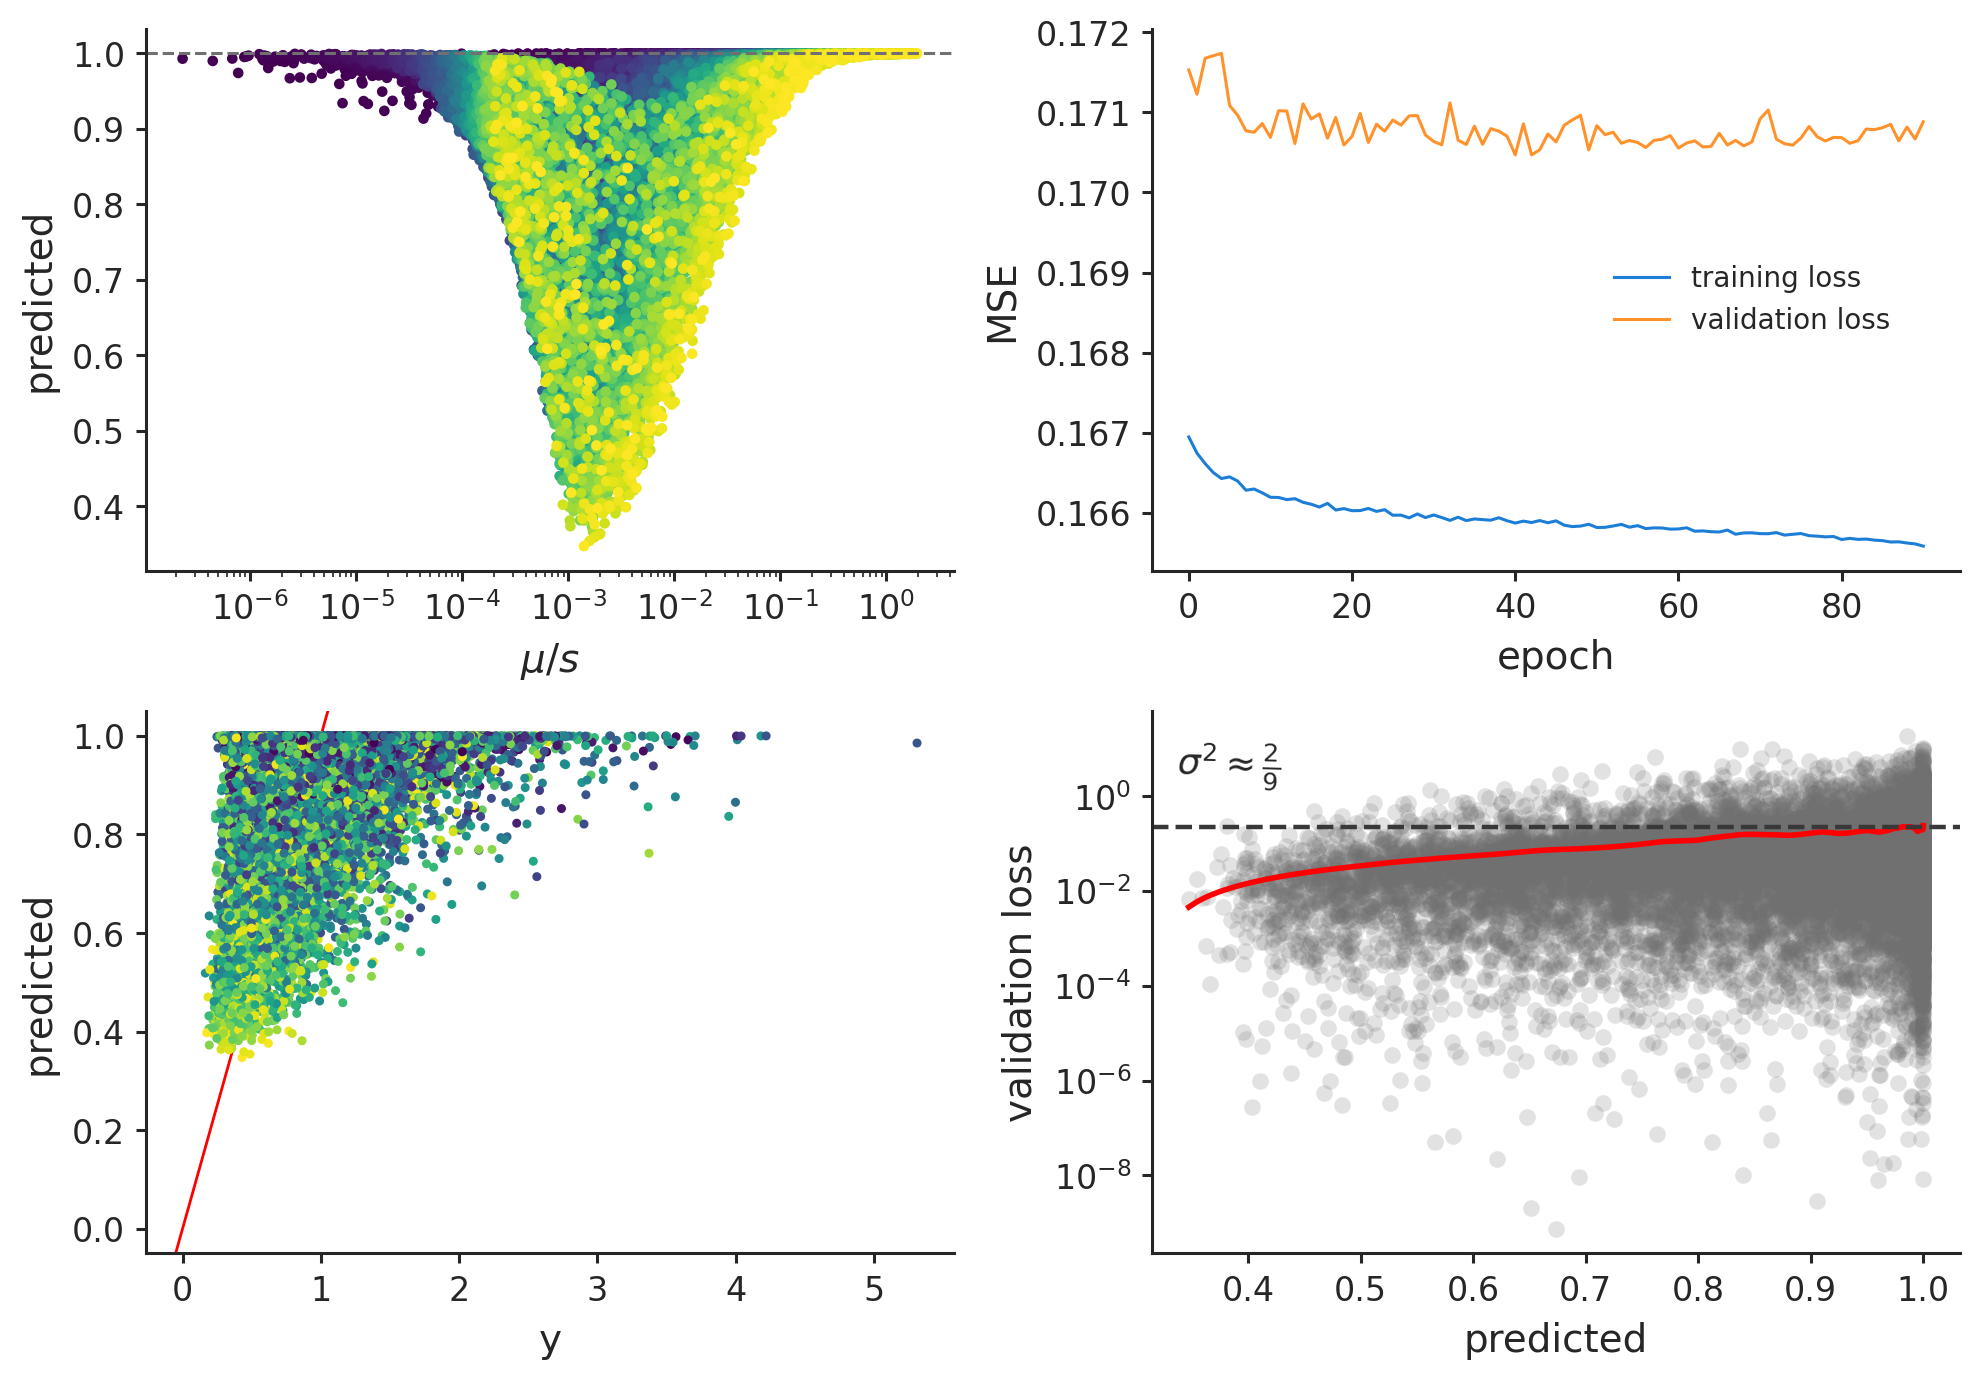

In [28]:
#y_theory = bgs_rec(func.X_test_orig[:, 0], func.X_test_orig[:, 1], func.X_test_orig[:, 2], 1000)

s_test, mu_test, rbp_test, rf_test, L_test = func.X_test_orig.T
rate = mu_test/10**s_test

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 7))

norm = plt.Normalize(np.min(mu_test), np.max(mu_test))

idx = np.argsort(mu_test)

ax1.scatter(rate[idx], predict[idx], c=mu_test[idx], cmap='viridis', s=8)
ax1.set_xlabel("$\mu/s$")
ax1.set_ylabel("predicted")
ax1.axhline(1, c='0.44', linestyle='dashed')
ax1.semilogx()
#cax1 = fig.add_axes([0.27, 0.8, 0.5, 0.05])
#fig.colorbar(cmap=cm.viridis, cax=cax1, orientation='horizontal')

#n = 10
#yedges = np.linspace(y_test.min(), y_test.max(), n)
#xedges = np.linspace(predict.min(), predict.max(), n)
#H, xedges, yedges = np.histogram2d(y_test.squeeze(), predict, bins=(xedges, yedges))
#X, Y = np.meshgrid(xedges, yedges)
#ax3.pcolormesh(X, Y, H)
ax3.scatter(func.y_test, predict, c=func.X_test[:, 1], s=5)
ax3.axline((0, 0), slope=1, c='r', linewidth=1, zorder=0)
ax3.set_xlabel('y')
ax3.set_ylabel('predicted')

ly = (predict - func.y_test.squeeze())**2
lX = predict
ax4.scatter(lX, ly, color='0.44', 
            linewidth=0, edgecolor='black', alpha=0.2)
#ax4.set_ylim(-0.1, 3)
z = lowess(ly, lX, frac= 1/10, it=0)
ax4.plot(z[:, 0], z[:, 1], c='r', linewidth=2)

# the lowess fit was sensitive to it=0; this shows that the it=0 
# case is nearly identical to OLS, e.g. right thing to do
#mod = sm.OLS(ly, sm.add_constant(lX))
#res = mod.fit()
#lX_new = sm.add_constant(np.linspace(0.4, 1, 100))
#ax4.plot(lX_new, res.predict(lX_new), c='g')

xnew = np.linspace(0.4, 1, 100)
def B_var_limit(B, N, mu=1):
    return (3*mu + 8*B*N*mu**2)/(36*B*N)
ax4.axhline(B_var_limit(1, 1000), c='0.22', linewidth=1.6, linestyle='dashed') # Note the 1/2 factor — see sim_power.ipynb! TODO
#ax4.text(0.03, 0.88, "$\sigma^2 = \\frac{3 \mu + 8 B N \mu}{36 B N}$", size=13, rotation=-1.5, transform=ax4.transAxes)
ax4.text(0.03, 0.88, "$\sigma^2 \\approx \\frac{2}{9}$", size=13, rotation=-1.5, transform=ax4.transAxes)
ax4.semilogy()
ax4.set_ylabel('validation loss')
ax4.set_xlabel('predicted')

ax2.plot(history.history['loss'][1:], label='training loss')
ax2.plot(history.history['val_loss'][1:], label='validation loss')
ax2.set_ylabel("MSE")
ax2.set_xlabel("epoch")
#ax2.set_ylim((0, 1))
ax2.legend()
plt.tight_layout()

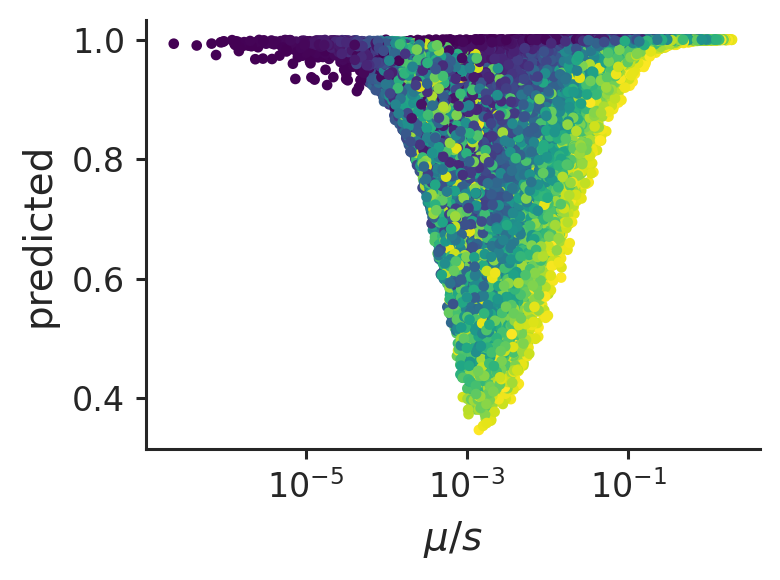

In [29]:
fig, ax  = plt.subplots(figsize=(4, 3))

ax.scatter(rate, predict, c=mu_test, cmap='viridis', s=8)
ax.set_xlabel("$\mu/s$")
ax.set_ylabel("predicted")
ax.semilogx()

plt.tight_layout()

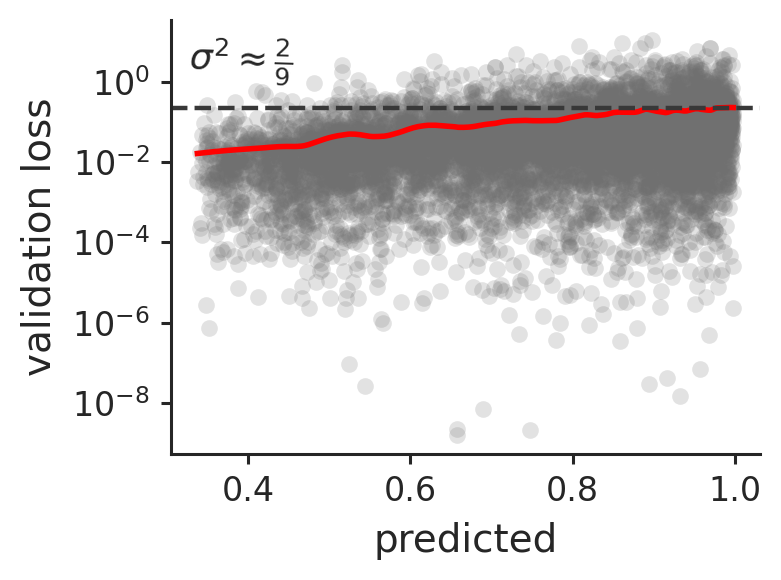

In [42]:
fig, ax  = plt.subplots(figsize=(4, 3))
ly = (predict - func.y_test.squeeze())**2
lX = predict
ax.scatter(lX, ly, color='0.44', 
            linewidth=0, edgecolor='black', alpha=0.2)
#ax4.set_ylim(-0.1, 3)
z = lowess(ly, lX, frac= 1/10, it=0)
ax.plot(z[:, 0], z[:, 1], c='r', linewidth=2)

ax.axhline(B_var_limit(1, 1000), c='0.22', linewidth=1.6, linestyle='dashed') # Note the 1/2 factor — see sim_power.ipynb! TODO
#ax4.text(0.03, 0.88, "$\sigma^2 = \\frac{3 \mu + 8 B N \mu}{36 B N}$", size=13, rotation=-1.5, transform=ax4.transAxes)
ax.text(0.03, 0.88, "$\sigma^2 \\approx \\frac{2}{9}$", size=13, rotation=-1.5, transform=ax.transAxes)
ax.semilogy()
ax.set_ylabel('validation loss')
ax.set_xlabel('predicted')
plt.tight_layout()
fig.savefig('/home/vsb/val_loss.pdf')

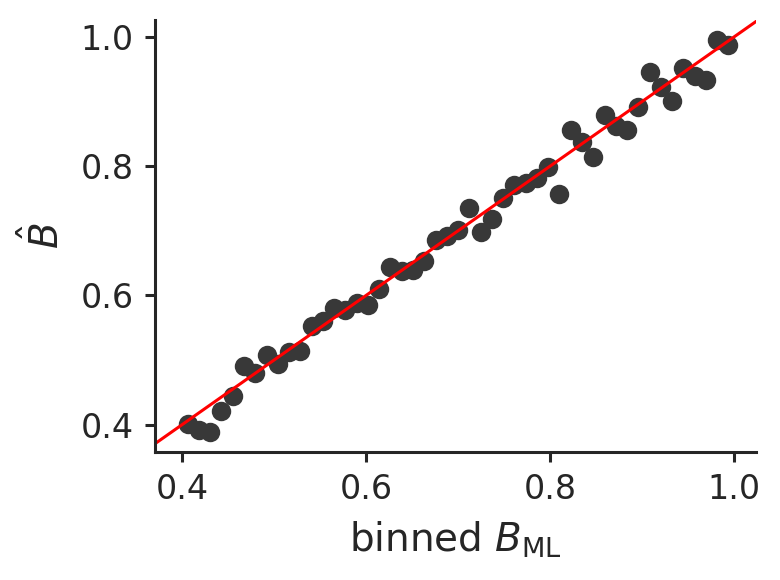

In [30]:
bins = np.linspace(0.4, 1, 50)
ytest_bins = stats.binned_statistic(predict, func.y_test.squeeze(), bins=bins)
fig, ax = plt.subplots(figsize=(4, 3))
ax.scatter(0.5*(bins[1:] + bins[:-1]), ytest_bins.statistic, c='0.22')
ax.set_ylabel('$\hat{B}$')
ax.set_xlabel('binned $B_\mathrm{ML}$')
ax.axline((0.4, 0.4), slope=1, c='r')
plt.tight_layout()


In [71]:
# Note that the training data does not log10 mu, but here we do (otherwise the grid looks
# like chunky peanut butter).
(s_grid, mu_grid, *_), X_mesh_orig, X_mesh, predict_grid = func.predict_grid({'mu': 101, 's': 100}, 
                                                                            fix_X={'rf': np.log10(1e-8),
                                                                                   'rbp': 1e-8,
                                                                                    'L': 1_000},
                                                                            log10=('mu'))

In [72]:
func.features

{'s': 0, 'mu': 1, 'rbp': 2, 'rf': 3, 'L': 4}

In [73]:
X_mesh_orig

array([[-5.30100000e+00,  5.50000000e-09,  1.00000000e-08,
        -8.00000000e+00,  1.00000000e+03],
       [-5.26059596e+00,  5.50000000e-09,  1.00000000e-08,
        -8.00000000e+00,  1.00000000e+03],
       [-5.22019192e+00,  5.50000000e-09,  1.00000000e-08,
        -8.00000000e+00,  1.00000000e+03],
       ...,
       [-1.38180808e+00,  1.00000000e-05,  1.00000000e-08,
        -8.00000000e+00,  1.00000000e+03],
       [-1.34140404e+00,  1.00000000e-05,  1.00000000e-08,
        -8.00000000e+00,  1.00000000e+03],
       [-1.30100000e+00,  1.00000000e-05,  1.00000000e-08,
        -8.00000000e+00,  1.00000000e+03]])

In [74]:
np.log10(5.5e-9)

-8.259637310505756

In [81]:
ncontour = np.linspace(0.4, 0.96, 8)

Z = bgs_segment(X_mesh_orig[:, 1], 10**X_mesh_orig[:, 0], 10**X_mesh_orig[:, 3], X_mesh_orig[:, 2],  X_mesh_orig[:, 4]).reshape(predict_grid.shape).squeeze().T
Zp = predict_grid.squeeze().T

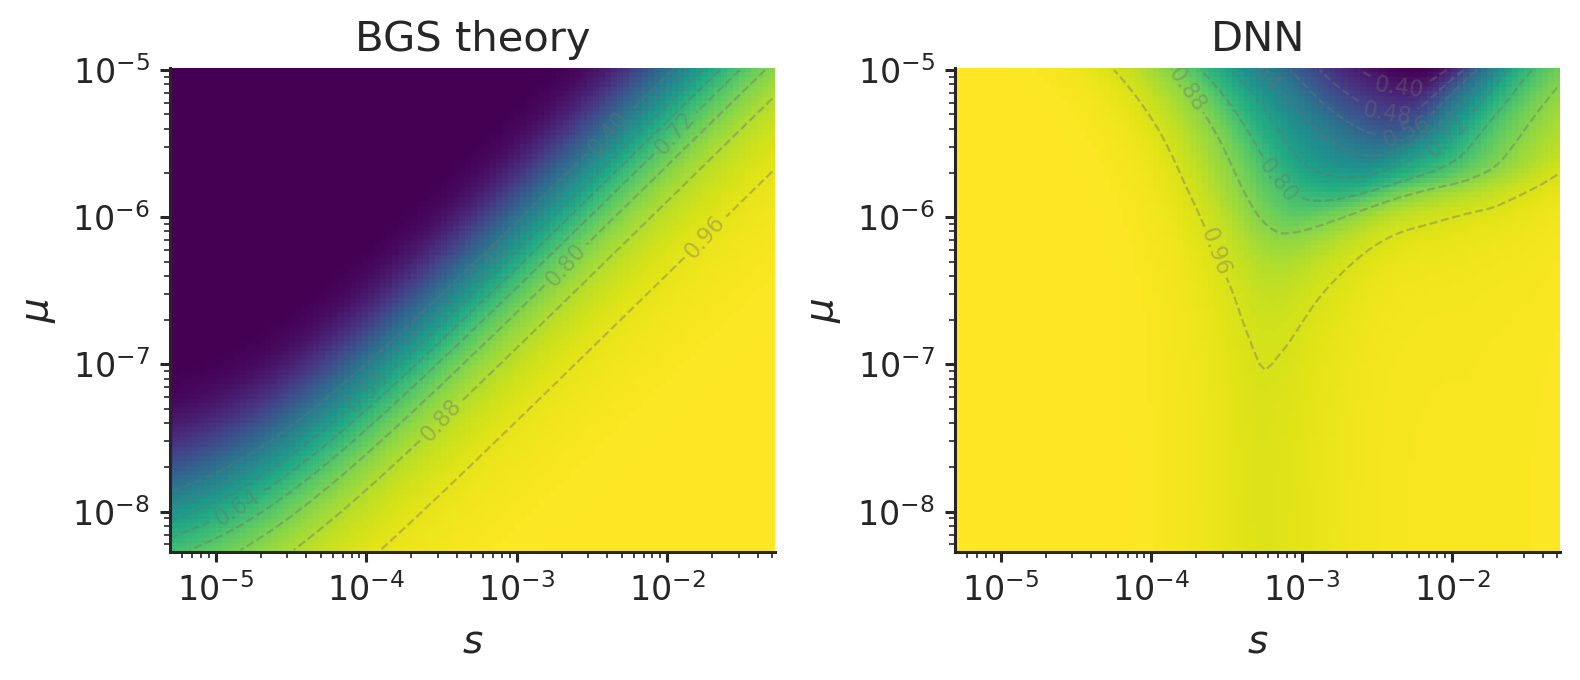

In [82]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 3.5))
surface_plot(s_grid, mu_grid, Z.T, scale='loglog', ylabel="$\mu$", xlabel="$s$", ncontour=ncontour, figax=(fig, ax[0]))
surface_plot(s_grid, mu_grid, Zp.T, scale='loglog', ylabel="$\mu$", xlabel="$s$", ncontour=ncontour, figax=(fig, ax[1]))
ax[0].set_title("BGS theory")
ax[1].set_title("DNN")
plt.tight_layout()

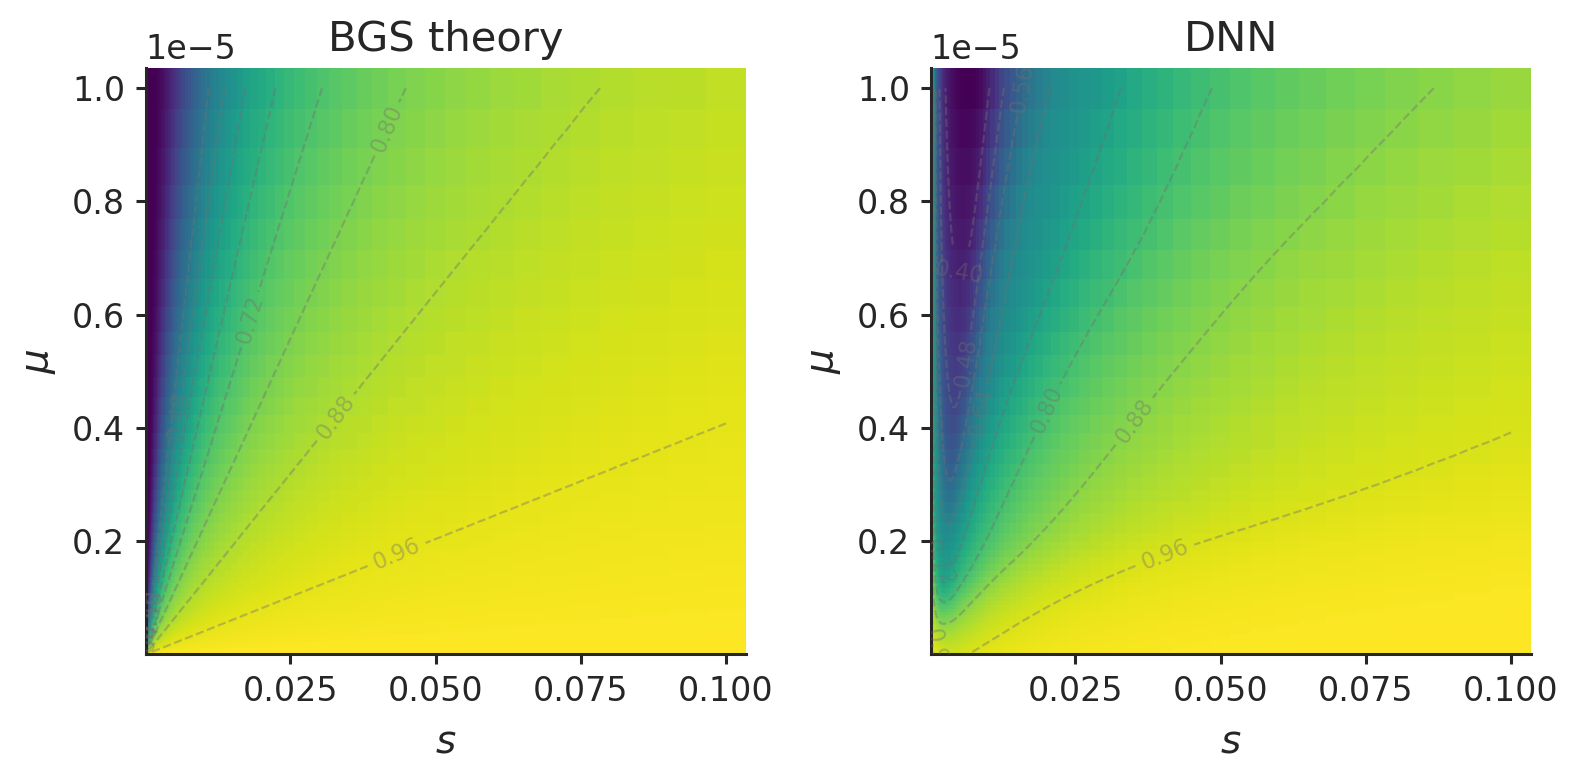

In [51]:
fig, ax = plt.subplots(ncols=2)
surface_plot(s_grid, mu_grid, Z, scale=None, ylabel="$\mu$", xlabel="$s$", ncontour=ncontour, figax=(fig, ax[0]))
surface_plot(s_grid, mu_grid, Zp, scale=None, ylabel="$\mu$", xlabel="$s$", ncontour=ncontour, figax=(fig, ax[1]))
ax[0].set_title("BGS theory")
ax[1].set_title("DNN")
plt.tight_layout()

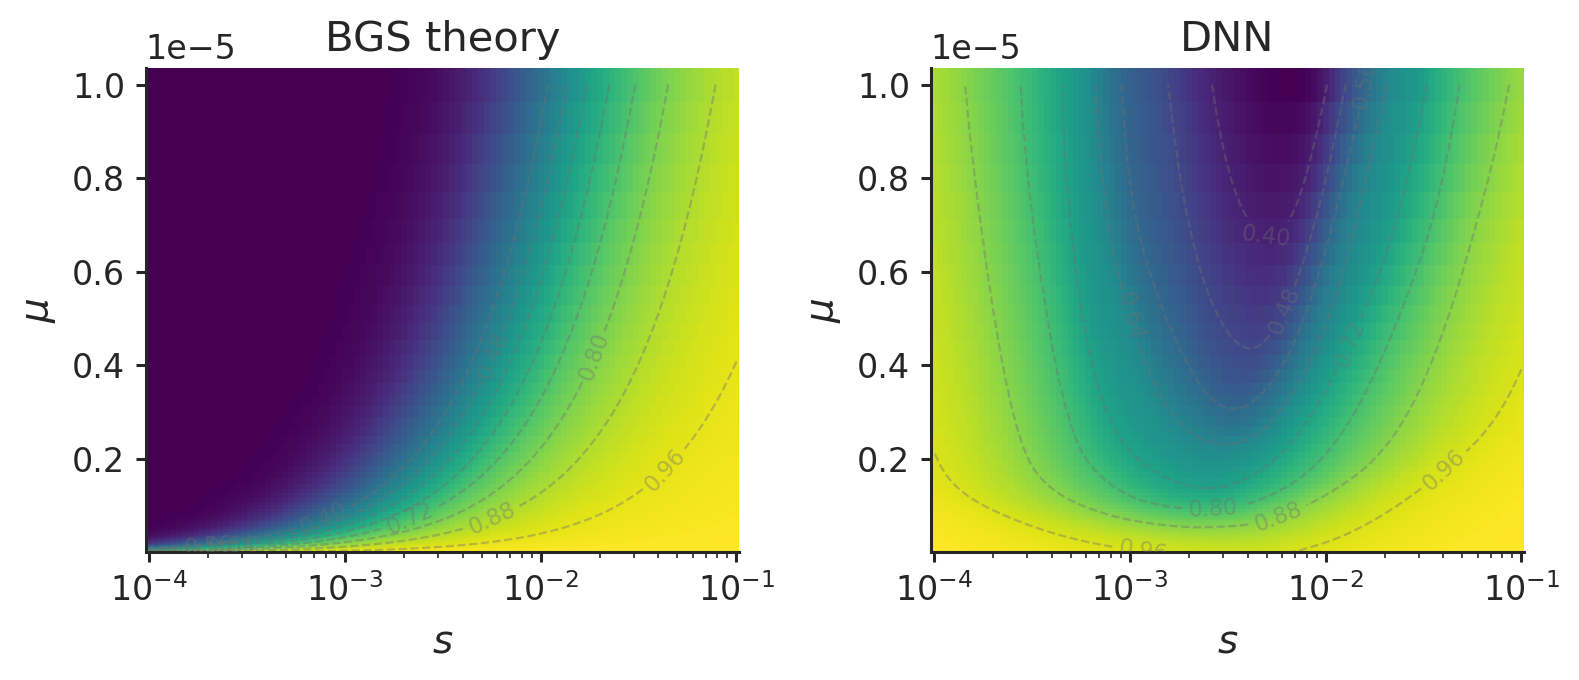

In [52]:

fig, ax = plt.subplots(ncols=2, figsize=(8, 3.5))
surface_plot(s_grid, mu_grid, Z, scale='semilogx', ylabel="$\mu$", xlabel="$s$", ncontour=ncontour, figax=(fig, ax[0]))
surface_plot(s_grid, mu_grid, Zp, scale='semilogx', ylabel="$\mu$", xlabel="$s$", ncontour=ncontour, figax=(fig, ax[1]))
ax[0].set_title("BGS theory")
ax[1].set_title("DNN")
plt.tight_layout() 
fig.savefig('/home/vsb/B_surface.pdf')

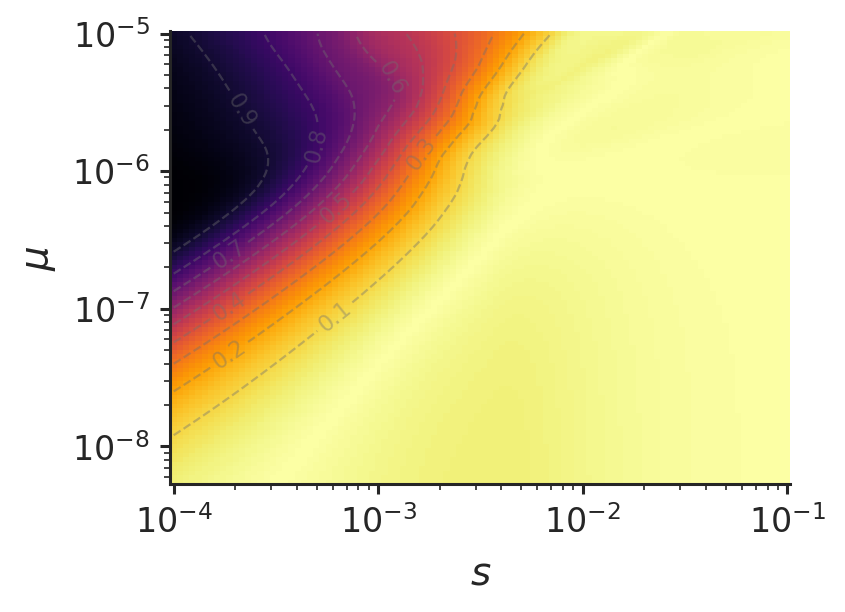

In [53]:
Zdiff = np.abs(Z-Zp)
figax = plt.subplots(figsize=(4, 3))
surface_plot(s_grid, mu_grid, Zdiff, scale='loglog', ylabel="$\mu$", xlabel="$s$", ncontour=10, cmap='inferno_r', figax=figax)
fig.savefig('/home/vsb/error_surface.pdf')

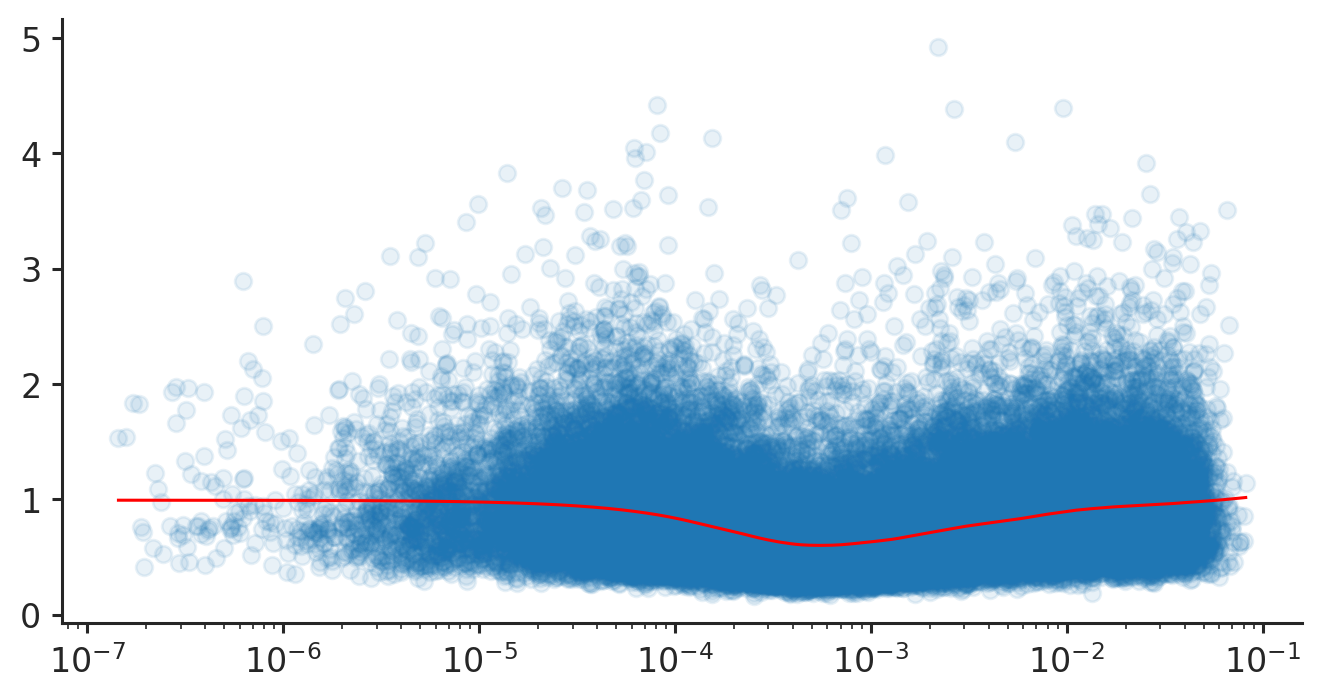

In [240]:
idx = Xo[:, 4] < 1
rate = Xo[idx, 3]/Xo[idx, 1]
yy = yo[idx, 1]
fig, ax = plt.subplots()
ax.scatter(rate, yy, alpha=0.1)

z = lowess(yy, rate, frac= 1./3, it=0)
ax.plot(z[:, 0], z[:, 1], c='r')
ax.set_xscale('log')

- make a kernel ridge vs DNN predicted surface plot
- weak impact on B can be caused by both BGS and weak selection
- is the mulitplicative right?


In [241]:
X.shape, y.shape


((57783, 3), (57783, 1))

/tmp/ipykernel_1377/1219890557.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'$10^{{{int(x)}}}$' for x in ax.get_xticks()])


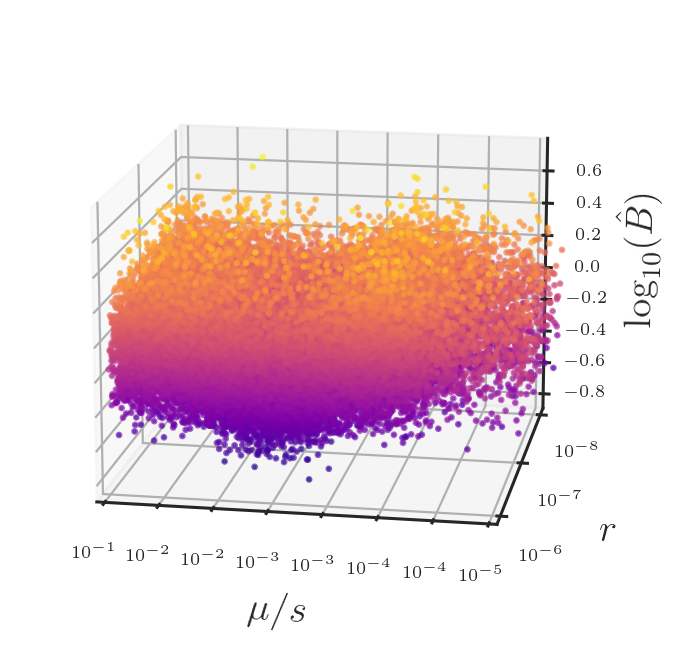

In [323]:
plt.rcParams['text.usetex'] = True

fig = plt.figure()
ax = plt.axes(projection='3d')

idx = (np.log10(X[:, 0]/X[:, 1]) > -5.3) & (np.log10(X[:, 0]/X[:, 1]) < -1.5)
Xtr = X[idx, :]
ax.scatter(np.log10(Xtr[:, 0]/Xtr[:, 1]), np.log10(Xtr[:, 2]), np.log10(y[idx]), s=2,
           c=np.log10(y[idx]), alpha=0.6, cmap='plasma')

#ax.view_init(5, 270)
ax.view_init(15, 100)
ax.set_xlim(-5, -1.5)
ax.set_xlabel('$\\mu/s$')
ax.set_ylabel('$r$')
ax.set_zlabel('$\\log_{10}(\\hat{B})$')
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_xticklabels([f'$10^{{{int(x)}}}$' for x in ax.get_xticks()])
ax.set_yticks(np.linspace(-8, -6, 3))
ax.set_yticklabels([f'$10^{{{int(x)}}}$' for x in ax.get_yticks()])
fig.savefig('/home/vsb/B3D.pdf')